In [1]:
# imports
import pandas as pd
import numpy as np
import wfdb
import ast
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Conv2D, MaxPooling2D, Reshape, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

In [2]:
#Load raw data
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = os.getcwd()+'/'
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv('data/physionet/ptbxl_database.csv', index_col='ecg_id')

# only take top x rows
#Y = Y.head(18000)
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

In [3]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('data/physionet/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [4]:
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# create Y to target superclasses with 'CD' in them
y = Y['diagnostic_superclass'].astype(str).str.contains('CD').astype(int)

In [5]:
print(Y['diagnostic_superclass'].value_counts())

[NORM]                 9069
[MI]                   2532
[STTC]                 2400
[CD]                   1708
[MI, CD]               1297
[STTC, HYP]             781
[STTC, MI]              595
[HYP]                   535
[STTC, CD]              471
[]                      411
[NORM, CD]              407
[STTC, MI, HYP]         358
[CD, HYP]               300
[STTC, MI, CD]          223
[STTC, CD, HYP]         211
[MI, HYP]               183
[STTC, MI, CD, HYP]     155
[MI, CD, HYP]           117
[NORM, STTC]             28
[NORM, STTC, CD]          5
[MI, STTC]                4
[MI, STTC, HYP]           3
[NORM, CD, HYP]           2
[NORM, HYP]               2
[MI, STTC, CD, HYP]       1
[NORM, MI, CD, HYP]       1
Name: diagnostic_superclass, dtype: int64


In [ ]:
#Remove records with missing ECGs

# Find all records that have at least one missing value in the 12-length arrays
missing_values_mask = np.any(np.isnan(X), axis=(1,2)) | np.any(np.apply_along_axis(lambda x: len(x)==0, axis=2, arr=X), axis=1)

# Get the indices of the records that have missing values
missing_values_indices = np.where(missing_values_mask)[0]
data_without_missing_values = X[~missing_values_mask]

print("Indices of removed records:", missing_values_indices)


In [6]:
#filter data using ECGMatrix
from filters.ecgMatrix import ecgMatrix

ecgm = ecgMatrix(X)
X_filtered = ecgm.fit()

In [7]:
# Split data into training and testing sets
y = y.reset_index(drop=True)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

In [8]:
print(len(X_train_valid))
print(len(y_train_valid))

17439
17439


In [9]:
# Assuming y is a 1D numpy array of class labels
classes, counts = np.unique(y_train_valid, return_counts=True)

# Print the class distribution as percentages
total_samples = len(y_train_valid)
for i, c in enumerate(classes):
    class_pct = counts[i] / total_samples * 100
    print('Class {} makes up {:.2f}% of the data'.format(c, class_pct))

Class 0 makes up 77.72% of the data
Class 1 makes up 22.28% of the data


In [10]:
y_train_valid = y_train_valid.reset_index(drop=True)
class_0_idx = y_train_valid[y_train_valid == 0].index

n_samples = 4500
sampled_class_0_idx = np.random.choice(class_0_idx, size=n_samples, replace=False)

class_1_idx = y_train_valid[y_train_valid == 1].index
idx_sampled = np.concatenate([sampled_class_0_idx, class_1_idx])
idx_sampled.sort()

X_downsampled = X_train_valid[idx_sampled, :]
y_downsampled = y_train_valid.iloc[idx_sampled]

In [11]:
# Assuming y is a 1D numpy array of class labels
classes, counts = np.unique(y_downsampled, return_counts=True)

# Print the class distribution as percentages
total_samples = len(y_downsampled)
for i, c in enumerate(classes):
    class_pct = counts[i] / total_samples * 100
    print('Class {} makes up {:.2f}% of the data'.format(c, class_pct))

Class 0 makes up 53.67% of the data
Class 1 makes up 46.33% of the data


In [12]:
# Split data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X_downsampled, y_downsampled, test_size=0.125, random_state=42)

In [13]:
# Define model architecture
model = Sequential()
model.add(Reshape((5000,12,1), input_shape=(5000,12)))
model.add(Conv2D(filters=32, kernel_size=(30,6), activation='relu'))
model.add(MaxPooling2D(pool_size=(10,2)))
model.add(Dropout(0.6))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4,1)))
model.add(Dropout(0.6))
model.add(Conv2D(filters=16, kernel_size=(4,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,1)))
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [14]:

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_validation, y_validation))

Epoch 1/20


2023-04-23 14:38:43.705798: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


29/29 [==============================] - 198s 7s/step - loss: 0.6965 - accuracy: 0.5278 - val_loss: 0.6923 - val_accuracy: 0.5148
Epoch 2/20
29/29 [==============================] - 193s 7s/step - loss: 0.6863 - accuracy: 0.5581 - val_loss: 0.6881 - val_accuracy: 0.5291
Epoch 3/20
29/29 [==============================] - 196s 7s/step - loss: 0.6757 - accuracy: 0.5675 - val_loss: 0.6792 - val_accuracy: 0.5415
Epoch 4/20
29/29 [==============================] - 194s 7s/step - loss: 0.6601 - accuracy: 0.6029 - val_loss: 0.6613 - val_accuracy: 0.5710
Epoch 5/20
29/29 [==============================] - 198s 7s/step - loss: 0.6264 - accuracy: 0.6604 - val_loss: 0.6324 - val_accuracy: 0.6940
Epoch 6/20
29/29 [==============================] - 192s 7s/step - loss: 0.6014 - accuracy: 0.6941 - val_loss: 0.5915 - val_accuracy: 0.7159
Epoch 7/20
29/29 [==============================] - 191s 7s/step - loss: 0.5693 - accuracy: 0.7140 - val_loss: 0.5773 - val_accuracy: 0.7302
Epoch 8/20
29/29 [======

In [15]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

137/137 [==============================] - 21s 150ms/step - loss: 0.4281 - accuracy: 0.8206
Test accuracy: 0.8206421732902527


In [18]:
# Use the trained model to make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.55).astype(int)
y_test_classes = y_test.values
# Print the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_classes, y_pred_classes)

137/137 [==============================] - 21s 149ms/step


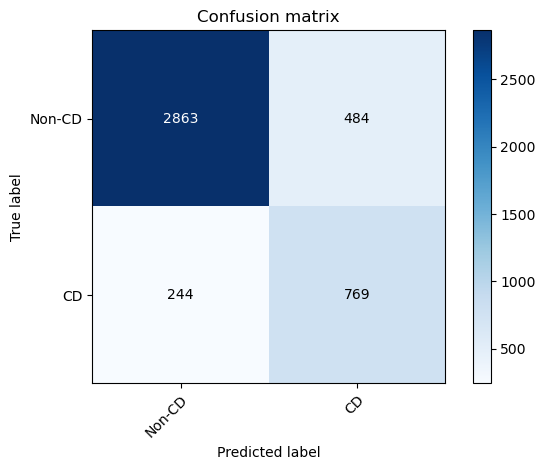

In [19]:
labels = ['Non-CD', 'CD']

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels, yticklabels=labels,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over the data and create a text annotation for each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

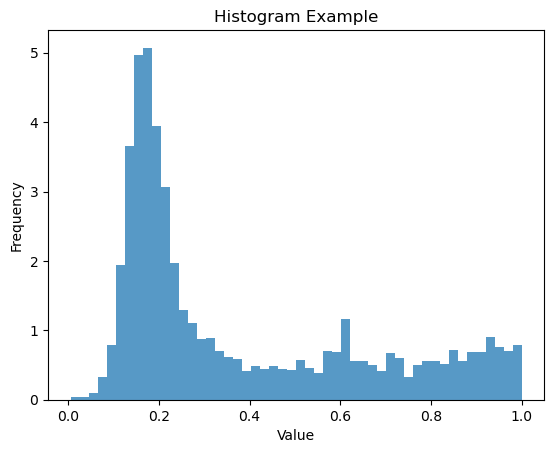

In [22]:
# Plot the histogram
plt.hist(y_pred, bins=50, density=True, alpha=0.75)

# Add axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')

# Display the plot
plt.show()

In [20]:
from sklearn.metrics import roc_auc_score

# y_pred is an array of predicted probabilities (e.g., output of predict_proba())
# y_test is an array of true labels (0 or 1)
auc = roc_auc_score(y_test, y_pred)

print('AUC:', auc)

AUC: 0.8734291084736194


In [21]:
#save model
save_model(model, 'CD_CNN_filtered')

INFO:tensorflow:Assets written to: CD_CNN_filtered/assets


INFO:tensorflow:Assets written to: CD_CNN_filtered/assets


In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
from ecgdetectors import Detectors

test = X_downsampled

detectors = Detectors(500)

results = []
for i in range(test.shape[0]):
    row_results = []
    for j in range(test.shape[2]):
        input = test[i,:,j]
        hrv = np.diff(detectors.pan_tompkins_detector(input))
        #average interval
        avg_interval = np.mean(hrv)
        #standard devation interval
        std_interval = np.std(hrv)
        #find percentage difference that are greater than 50ms
        hrv_diff = np.diff(hrv)
        over50ms = 0
        for diff in range(len(hrv_diff)):
            if abs(hrv_diff[diff])>25:
                over50ms += 1
        if len(hrv_diff)>0:
            percent_over_50 = over50ms/len(hrv_diff)
        else:
            percent_over_50 = 999

        
        row_results.append(avg_interval)
        row_results.append(std_interval)
        row_results.append(percent_over_50)
    results.append(row_results)

columns = []
for j in range(test.shape[2]):
    columns.append('waveform_{}_avg_int'.format(j+1))
    columns.append('waveform_{}_std_int'.format(j+1))
    columns.append('waveform_{}_diff_over_50ms'.format(j+1))
df = pd.DataFrame(results, columns=columns)

In [ ]:
y_downsampled = y_downsampled.reset_index(drop=True)
print(y_downsampled)

In [ ]:
df['target'] = y_downsampled
print(df.shape)
df.head(30)

In [ ]:
from pycaret.classification import *
mi_clf = setup(data = df, target='target')

In [ ]:
compare_models()